In [ ]:
# ライブラリのインストール
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 37.7 MB/s eta 0:00:00


自転車の現在地とホームポジションデータをランダムに生成

In [ ]:
import pandas as pd
import numpy as np

# シード値を設定
np.random.seed(4)

# 自転車の位置情報をランダムに生成
num_positions = 5  # 5個の位置情報を生成
min_coord, max_coord = 0, 100  # 座標の範囲（0から100）
home_positions = [(np.random.randint(min_coord, max_coord), np.random.randint(min_coord, max_coord)) for _ in range(num_positions)]

# 現在地情報（座標）をランダムに生成
current_locations = [(np.random.randint(min_coord, max_coord), np.random.randint(min_coord, max_coord)) for _ in range(num_positions)]

# データフレームを作成
bike_data = {
    'Home Position': home_positions,
    'Current Location': current_locations
}

df_bikes = pd.DataFrame(bike_data)

# Current Location == Home Positionの場合のデータを追加
num_same_positions = 5
same_locations =[(np.random.randint(min_coord, max_coord), np.random.randint(min_coord, max_coord)) for _ in range(num_same_positions)]
new_row = pd.DataFrame({'Home Position': same_locations, 'Current Location': same_locations})
df_bikes = pd.concat([df_bikes, new_row], ignore_index=True)

# 'Bike ID' 列を最初のカラムとして追加
df_bikes.insert(0, 'Bike ID', df_bikes.index)
# Bike ID をインデックスとして設定
df_bikes.set_index('Bike ID', inplace=True)

df_bikes

,Home Position,Current Location
Bike ID,,
0,"(46, 55)","(55, 55)"
1,"(69, 1)","(57, 36)"
2,"(87, 72)","(50, 44)"
3,"(50, 9)","(38, 52)"
4,"(58, 94)","(3, 0)"
5,"(55, 21)","(55, 21)"
6,"(21, 73)","(21, 73)"
7,"(38, 56)","(38, 56)"
8,"(66, 46)","(66, 46)"


ユーザー情報を別のデータフレームとして保持

In [ ]:
user_data = {
    'User': ['User 1', 'User 2'],
    'Current Position': [(58, 45), (70, 50)],
    'Destination': [(80, 80), (70, 70)]
}

df_users = pd.DataFrame(user_data)

# 'Assigned Bike ID' 列を追加し、初期値を -1 に設定
df_users['Assigned Bike ID'] = -1

# 'User ID' 列を最初のカラムとして追加
df_users.insert(0, 'User ID', df_users.index)
# User ID をインデックスとして設定
df_users.set_index('User ID', inplace=True)

df_users

,User,Current Position,Destination,Assigned Bike ID
User ID,,,,
0,User 1,"(58, 45)","(80, 80)",-1
1,User 2,"(70, 50)","(70, 70)",-1


以下の二種類の情報をプロットする
- 自転車の現在地とホームポジションまでの方向
- ユーザーの現在地と目的地までの方向

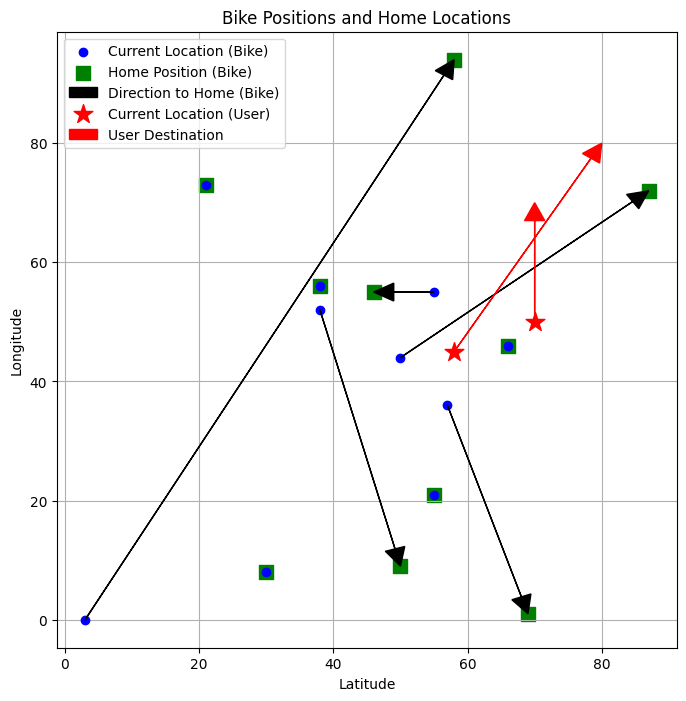

In [ ]:
import matplotlib.pyplot as plt

# プロットを作成
plt.figure(figsize=(8, 8))

# 自転車と自宅位置のプロット
for index, row in df_bikes.iterrows():
    # 現在地をプロット
    plt.scatter(row['Current Location'][0], row['Current Location'][1],
                marker='o', color='blue', zorder=2,
                label="Current Location (Bike)" if index == 0 else "")
    # 自宅位置をプロット
    plt.scatter(row['Home Position'][0], row['Home Position'][1],
                marker='s', color='green', s=100, zorder=1,
                label="Home Position (Bike)" if index == 0 else "")
    # 矢印をプロット
    # 見やすさの観点から矢印の長さを短くしてプロット
    plt.arrow(row['Current Location'][0], row['Current Location'][1],
              row['Home Position'][0] - row['Current Location'][0],
              row['Home Position'][1] - row['Current Location'][1],
              head_width=3, head_length=3, fc='black', ec='black',
              length_includes_head=True, zorder=3,
              label="Direction to Home (Bike)" if index == 0 else "")

# ユーザーの位置と目的地のプロット
for index, row in df_users.iterrows():
    # 現在地をプロット
    plt.scatter(row['Current Position'][0], row['Current Position'][1],
                marker='*', color='red', s=200, zorder=1,
                label="Current Location (User)" if index == 0 else "")
    # 矢印をプロット
    plt.arrow(row['Current Position'][0], row['Current Position'][1],
              row['Destination'][0] - row['Current Position'][0],
              row['Destination'][1] - row['Current Position'][1],
              head_width=3, head_length=3, fc='red', ec='red',
              length_includes_head=True, zorder=3,
              label="User Destination" if index == 0 else "")

# y軸をLatitudeに設定
plt.xlabel('Latitude')
# x軸をLongitudeに設定
plt.ylabel('Longitude')
plt.title('Bike Positions and Home Locations')
plt.grid(True)
plt.legend()
plt.show()

自転車の分散を定量的に評価する<br>
分散の具体的な評価方法としては，各々の自転車の現在地とホームポジションのユーグリッド距離を計算し，それらの総和を分散とする．<br>

$\sum_{b \in B} \underbrace{\| \mathbf{v}_b \|}_{\text{現在地からホームポジションへの方向ベクトルのノルムの総和}}$

【TODO】今後の課題としては，ユーグリッド距離よりもマンハッタン距離を用いたほうが本質的な自転車の分散を取得することができるため検討する．

In [ ]:
def calculate_total_distance(df):
    """
    データフレームからホームポジションとカレントポジションのノルムの総和を計算する関数。

    :param df: ホームポジションとカレントポジションを含むデータフレーム
    :return: 距離の総和
    """
    total_distance = 0
    for _, row in df.iterrows():
        home_pos = np.array(row['Home Position'])
        current_loc = np.array(row['Current Location'])
        distance = np.linalg.norm(home_pos - current_loc)
        total_distance += distance
    return total_distance

In [ ]:
# ホームポジションと現在地の距離の分散を計算
print("初期状態におけるノルムの総和：", calculate_total_distance(df_bikes))

初期状態におけるノルムの総和： 245.95167784260929


実際のユーザーの位置座標と目的地から数値実験を試みる

In [ ]:
def update_bike_location(df_bikes, bike_index, new_destination):
    """
    自転車の現在位置を更新する関数。新しい位置はnumpy配列で指定。

    :param df_bikes: 自転車情報を含むデータフレーム
    :param bike_index: 更新する自転車のインデックス
    :param new_destination: 新しい目的地（numpy配列形式の座標、例：np.array([x, y])）
    """

    # バリデーション
    # 実際に更新を試みる前に、インデックスとデータ型を確認
    if isinstance(new_destination, (list, np.ndarray)) and len(new_destination) == 2:
        try:
            # インデックスが有効か確認
            if bike_index in df_bikes.index:
                # 指定された自転車の現在位置を新しい目的地に更新
                # df_bikes.loc[bike_index, 'Current Location'] = tuple(new_destination)
                df_bikes.at[bike_index, 'Current Location'] = tuple(new_destination)
                # print("Update successful!")
                return df_bikes
            else:
                print("Error: bike_index is out of bounds.")
        except Exception as e:
            print("An error occurred:", e)
    else:
        print("Error: new_destination is not in the correct format or size.")


def update_user(df_users, user_index, assigned_bike_id, new_destination):
    """
    ユーザーの現在位置を更新する関数。新しい位置はnumpy配列で指定。

    :param df_users: ユーザー情報を含むデータフレーム
    :param user_index: 更新するユーザーのインデックス
    :param assigned_bike_id: ユーザーに割り当てられる自転車のID
    :param new_destination: 新しい目的地（numpy配列形式の座標、例：np.array([x, y])）
    """
    # ユーザーインデックスのバリデーション
    if user_index not in df_users.index:
        raise ValueError("指定されたuser_indexはデータフレームの範囲外です。")

    # new_destinationのバリデーション
    if not isinstance(new_destination, np.ndarray) or new_destination.shape != (2,):
        raise ValueError("new_destinationは2要素のnumpy配列である必要があります。")

    # assigned_bike_idのバリデーション
    if not isinstance(assigned_bike_id, int):
        raise ValueError("assigned_bike_idは整数である必要があります。")


    # 指定されたユーザーの現在位置を新しい目的地に更新
    df_users.at[user_index, 'Current Position'] = tuple(new_destination)
    # ユーザーに割り当てられた自転車IDを更新
    df_users.at[user_index, 'Assigned Bike ID'] = assigned_bike_id
    # 【WANT TO DO】この情報を履歴DBに格納する方にしたい。

    return df_users

In [ ]:
import pulp

# ユーザーごとに最適化を行う
for user_index, user_row in df_users.iterrows():
    user_position = np.array(user_row['Current Position'])
    destination = np.array(user_row['Destination'])

    # 制約(1): 半径rの距離内の自転車を特定
    radius = 16

    # 制約(2): radius内に利用可能な自転車が1つ以下の場合は半径を広げて探索(最大2回の拡張とする)
    loopIndex = 0
    MAX_SEARCH = 2
    available_bikes = []
    while len(available_bikes) < 2:
        for index, row in df_bikes.iterrows():
            distance = np.linalg.norm(np.array(row['Current Location']) - user_position)
            if distance <= radius:
                available_bikes.append(index)

        loopIndex += 1
        if loopIndex > MAX_SEARCH or len(available_bikes) >= 2:
            break;

        # 利用可能な自転車が無い場合、探索範囲を拡張
        radius += 2

    # モデルの定義
    # スペースをアンダースコアに変換
    user_name = user_row['User'].replace(' ', '_')
    model = pulp.LpProblem("Bike_Allocation_for_{}".format(user_name), pulp.LpMinimize)

    # 変数の定義
    bike_vars = pulp.LpVariable.dicts("Bike", available_bikes, cat="Binary")

    # 目的関数の定義: 移動後の自転車の目的地とホームポジションの距離(分散)を最小化
    model += pulp.lpSum([np.linalg.norm(np.array(df_bikes.loc[bike, 'Home Position']) - destination) * bike_vars[bike] for bike in available_bikes])

    # 制約条件の定義: 選択された自転車は1つと仮定
    # 【TO DO】実際は「1つ以下」という条件であるべきだが，そうするとマッチングしなくなってしまう。
    model += pulp.lpSum([bike_vars[bike] for bike in available_bikes]) == 1

    # 最適化の実行
    model.solve()

    # 結果の表示
    print("Optimization result for", user_row['User'])
    is_successed_optimization = False
    for bike in available_bikes:
        if pulp.value(bike_vars[bike]) == 1:
            # 更新処理
            df_bikes = update_bike_location(df_bikes, bike, destination)
            df_users = update_user(df_users, user_index, bike, destination)
            is_successed_optimization = True

            print("Assigned bike:", bike, "at location", df_bikes.loc[bike, 'Current Location'])
            print()
            break

    if not is_successed_optimization:
      print("適切な自転車が見つかりませんでした。")

Optimization result for User 1
Assigned bike: 2 at location (80, 80)

Optimization result for User 2
Assigned bike: 8 at location (70, 70)



In [ ]:
df_bikes

,Home Position,Current Location
Bike ID,,
0,"(46, 55)","(55, 55)"
1,"(69, 1)","(57, 36)"
2,"(87, 72)","(80, 80)"
3,"(50, 9)","(38, 52)"
4,"(58, 94)","(3, 0)"
5,"(55, 21)","(55, 21)"
6,"(21, 73)","(21, 73)"
7,"(38, 56)","(38, 56)"
8,"(66, 46)","(70, 70)"


In [ ]:
df_users

,User,Current Position,Destination,Assigned Bike ID
User ID,,,,
0,User 1,"(80, 80)","(80, 80)",2
1,User 2,"(70, 70)","(70, 70)",8


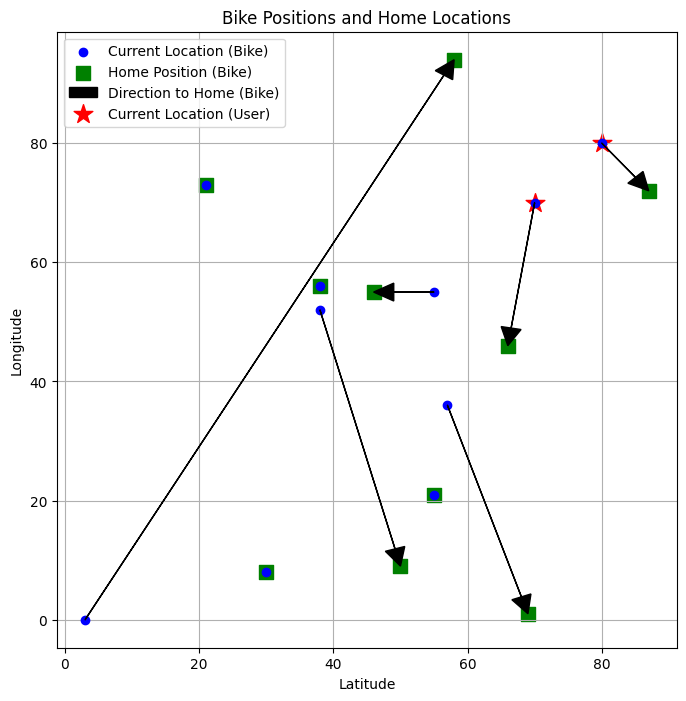

In [ ]:
import matplotlib.pyplot as plt

# プロットを作成
plt.figure(figsize=(8, 8))

# 自転車と自宅位置のプロット
for index, row in df_bikes.iterrows():
    # 現在地をプロット
    plt.scatter(row['Current Location'][0], row['Current Location'][1],
                marker='o', color='blue', zorder=2,
                label="Current Location (Bike)" if index == 0 else "")
    # 自宅位置をプロット
    plt.scatter(row['Home Position'][0], row['Home Position'][1],
                marker='s', color='green', s=100, zorder=1,
                label="Home Position (Bike)" if index == 0 else "")
    # 矢印をプロット
    # 見やすさの観点から矢印の長さを短くしてプロット
    plt.arrow(row['Current Location'][0], row['Current Location'][1],
              row['Home Position'][0] - row['Current Location'][0],
              row['Home Position'][1] - row['Current Location'][1],
              head_width=3, head_length=3, fc='black', ec='black',
              length_includes_head=True, zorder=3,
              label="Direction to Home (Bike)" if index == 0 else "")

# ユーザーの位置と目的地のプロット
for index, row in df_users.iterrows():
    # 現在地をプロット
    plt.scatter(row['Current Position'][0], row['Current Position'][1],
                marker='*', color='red', s=200, zorder=1,
                label="Current Location (User)" if index == 0 else "")

# y軸をLatitudeに設定
plt.xlabel('Latitude')
# x軸をLongitudeに設定
plt.ylabel('Longitude')
plt.title('Bike Positions and Home Locations')
plt.grid(True)
plt.legend()
plt.show()

キューとして保持していたユーザーのデータフレームにおいて、マッチングが成立したデータを削除する。

In [ ]:
# 'Assigned Bike ID'が-1ではない行を削除
df_users = df_users[df_users['Assigned Bike ID'] == -1]

# 結果の表示
df_users

,User,Current Position,Destination,Assigned Bike ID
User ID,,,,


In [ ]:
print("移動後の自転車のノルムの総和:", calculate_total_distance(df_bikes))

移動後の自転車のノルムの総和: 234.5124427440561


ランダムに生成した100ユーザーでシミュレートしてみる

In [ ]:
# 100人分のランダムな現在位置と目的地を生成
current_positions = [(np.random.randint(0, 100), np.random.randint(0, 100)) for _ in range(100)]
destinations = [(np.random.randint(0, 100), np.random.randint(0, 100)) for _ in range(100)]

# ユーザーデータの辞書を作成
user_data = {
    'User': [f'User {i + 1}' for i in range(100)],
    'Current Position': current_positions,
    'Destination': destinations,
    'Assigned Bike ID': [-1] * 100  # すべてのユーザーに対して初期値 -1 を設定
}

# データフレームの作成
df_users = pd.DataFrame(user_data)

# 'User ID' 列を最初のカラムとして追加し、インデックスとして設定
df_users.insert(0, 'User ID', df_users.index)
df_users.set_index('User ID', inplace=True)

# 結果の表示
df_users


,User,Current Position,Destination,Assigned Bike ID
User ID,,,,
0,User 1,"(39, 49)","(19, 28)",-1
1,User 2,"(84, 28)","(50, 87)",-1
2,User 3,"(73, 34)","(49, 7)",-1
3,User 4,"(6, 7)","(93, 26)",-1
4,User 5,"(68, 36)","(18, 96)",-1
...,...,...,...,...
95,User 96,"(73, 74)","(10, 0)",-1
96,User 97,"(40, 16)","(15, 12)",-1
97,User 98,"(29, 40)","(33, 87)",-1


ユーザー100人に対して最適化を実行する

【TO DO】この処理は複数箇所で出現しているため、共通化したい。

In [ ]:
import pulp

# ユーザーごとに最適化を行う
for user_index, user_row in df_users.iterrows():
    user_position = np.array(user_row['Current Position'])
    destination = np.array(user_row['Destination'])

    # 制約(1): 半径rの距離内の自転車を特定
    radius = 16

    # 制約(2): radius内に利用可能な自転車が1つ以下の場合は半径を広げて探索(最大2回の拡張とする)
    loopIndex = 0
    MAX_SEARCH = 2
    available_bikes = []
    while len(available_bikes) < 2:
        for index, row in df_bikes.iterrows():
            distance = np.linalg.norm(np.array(row['Current Location']) - user_position)
            if distance <= radius:
                available_bikes.append(index)

        loopIndex += 1
        if loopIndex > MAX_SEARCH or len(available_bikes) >= 2:
            break;

        # 利用可能な自転車が無い場合、探索範囲を拡張
        radius += 2

    # モデルの定義
    # スペースをアンダースコアに変換
    user_name = user_row['User'].replace(' ', '_')
    model = pulp.LpProblem("Bike_Allocation_for_{}".format(user_name), pulp.LpMinimize)

    # 変数の定義
    bike_vars = pulp.LpVariable.dicts("Bike", available_bikes, cat="Binary")

    # 目的関数の定義: 移動後の自転車の目的地とホームポジションの距離(分散)を最小化
    model += pulp.lpSum([np.linalg.norm(np.array(df_bikes.loc[bike, 'Home Position']) - destination) * bike_vars[bike] for bike in available_bikes])

    # 制約条件の定義: 選択された自転車は1つと仮定
    # 【TO DO】実際は「1つ以下」という条件であるべきだが，そうするとマッチングしなくなってしまう。
    model += pulp.lpSum([bike_vars[bike] for bike in available_bikes]) == 1

    # 最適化の実行
    model.solve()

    # 結果の表示
    print("Optimization result for", user_row['User'])
    is_successed_optimization = False
    for bike in available_bikes:
        if pulp.value(bike_vars[bike]) == 1:
            # 更新処理
            df_bikes = update_bike_location(df_bikes, bike, destination)
            df_users = update_user(df_users, user_index, bike, destination)
            is_successed_optimization = True

            print("Assigned bike:", bike, "at location", df_bikes.loc[bike, 'Current Location'])
            print()
            break

    if not is_successed_optimization:
      print("適切な自転車が見つかりませんでした。")

# 結果の表示
df_users

Optimization result for User 1
Assigned bike: 7 at location (19, 28)

Optimization result for User 2
適切な自転車が見つかりませんでした。
Optimization result for User 3
適切な自転車が見つかりませんでした。
Optimization result for User 4
適切な自転車が見つかりませんでした。
Optimization result for User 5
適切な自転車が見つかりませんでした。
Optimization result for User 6
適切な自転車が見つかりませんでした。
Optimization result for User 7
適切な自転車が見つかりませんでした。
Optimization result for User 8
適切な自転車が見つかりませんでした。
Optimization result for User 9
Assigned bike: 8 at location (45, 1)

Optimization result for User 10
適切な自転車が見つかりませんでした。
Optimization result for User 11
Assigned bike: 8 at location (52, 93)

Optimization result for User 12
適切な自転車が見つかりませんでした。
Optimization result for User 13
Assigned bike: 7 at location (81, 40)

Optimization result for User 14
適切な自転車が見つかりませんでした。
Optimization result for User 15
適切な自転車が見つかりませんでした。
Optimization result for User 16
適切な自転車が見つかりませんでした。
Optimization result for User 17
適切な自転車が見つかりませんでした。
Optimization result for User 18
Assigned bike: 7 at location (6

キューとして保持していたユーザーのデータフレームにおいて、マッチングが成立したデータを削除する。

【TO DO】キュー配列の更新関数を作成する必要がある。

In [ ]:
# 'Assigned Bike ID'が-1ではない行を削除
df_users = df_users[df_users['Assigned Bike ID'] == -1]

# 結果の表示
df_users

,User,Current Position,Destination,Assigned Bike ID
User ID,,,,
1,User 2,"(84, 28)","(50, 87)",-1
2,User 3,"(73, 34)","(49, 7)",-1
3,User 4,"(6, 7)","(93, 26)",-1
4,User 5,"(68, 36)","(18, 96)",-1
5,User 6,"(8, 40)","(9, 43)",-1
...,...,...,...,...
93,User 94,"(98, 84)","(23, 26)",-1
94,User 95,"(54, 48)","(2, 99)",-1
97,User 98,"(29, 40)","(33, 87)",-1


ユーザー数100人でシミュレートした結果をプロット

【TO DO】プロットする部分を共通化する必要がある。何をプロットするのか否かを引数として受け取って図を出力したい。

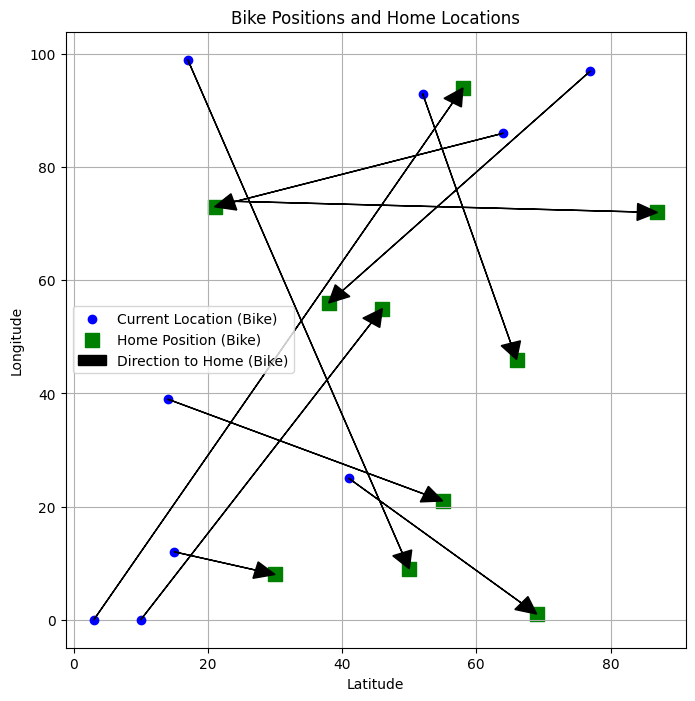

In [ ]:
import matplotlib.pyplot as plt

# プロットを作成
plt.figure(figsize=(8, 8))

# 自転車と自宅位置のプロット
for index, row in df_bikes.iterrows():
    # 現在地をプロット
    plt.scatter(row['Current Location'][0], row['Current Location'][1],
                marker='o', color='blue', zorder=2,
                label="Current Location (Bike)" if index == 0 else "")
    # 自宅位置をプロット
    plt.scatter(row['Home Position'][0], row['Home Position'][1],
                marker='s', color='green', s=100, zorder=1,
                label="Home Position (Bike)" if index == 0 else "")
    # 矢印をプロット
    # 見やすさの観点から矢印の長さを短くしてプロット
    plt.arrow(row['Current Location'][0], row['Current Location'][1],
              row['Home Position'][0] - row['Current Location'][0],
              row['Home Position'][1] - row['Current Location'][1],
              head_width=3, head_length=3, fc='black', ec='black',
              length_includes_head=True, zorder=3,
              label="Direction to Home (Bike)" if index == 0 else "")

# ユーザーの位置と目的地のプロット
# for index, row in df_users.iterrows():
#     # 現在地をプロット
#     plt.scatter(row['Current Position'][0], row['Current Position'][1],
#                 marker='*', color='red', s=200, zorder=1,
#                 label="Current Location (User)" if index == 0 else "")

# y軸をLatitudeに設定
plt.xlabel('Latitude')
# x軸をLongitudeに設定
plt.ylabel('Longitude')
plt.title('Bike Positions and Home Locations')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print("移動後の自転車のノルムの総和:", calculate_total_distance(df_bikes))

移動後の自転車のノルムの総和: 582.2617966980371
